In [1]:
import openmm as mm
import openmm.app as app
import openmm.unit as unit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams['figure.figsize'] = 18, 4

# Running the Langevin dynamics simulation of a particle in a 3D double well potential

## The 3D Double Well Potential

Let's simulate the Langevin dynamics of a single particle with 100 amus of mass at 300K in a three dimensional double well potential:

In [3]:
n_particles = 1
mass = 100.0 * unit.amu
temperature = 300.0*unit.kelvin
friction = 1.0/unit.picosecond

The double well potential is described by the following expression:

\begin{equation}
V(x,y,z)=E_{0}\left[ \left(\frac{x}{a}\right)^4 -2\left(\frac{x}{a}\right)^2 \right]-\frac{b}{a}x + \frac{1}{2}k\left( y^2 + z^2 \right)
\end{equation}

This potential can be split in two summands, the first one with the potential for the $X$ axis, and a second term with the potential for the $Y$ and $Z$ axes:

\begin{equation}
V(x,y,z)=V_{x}(x)+V_{y,z}(y,z)
\end{equation}

We will work with the following potential parameters:

In [4]:
Eo=3.0 * unit.kilocalories_per_mole # barrier height when b=0.
a=5.0 * unit.angstroms # Distance from the origin to the minima when b=0.
b=0.0 * unit.kilocalories_per_mole # Linear force factor to make the potential asymmetric (b!=0)
k=1.0 * unit.kilocalories_per_mole/unit.angstrom**2 # harmonic constant in Y and Z

### Along X
You can play with the parameters to see their effect on the potential energy terms corresponding to the double well in $X$:

In [5]:
def double_well_potential_1D(x,Eo,a,b):
    return Eo*((x/a)**4-2*(x/a)**2)-(b/a)*x

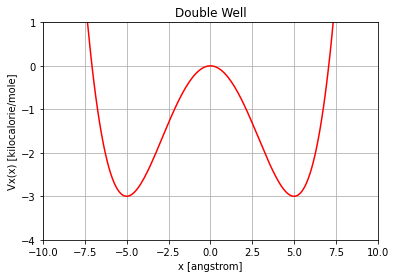

In [6]:
x_lims = [-50.0, 50.0] * unit.angstroms
delta_x = 0.1 * unit.angstroms
x_bins = np.arange(x_lims[0]._value, x_lims[1]._value, delta_x._value)*unit.angstroms
x_centers = (x_bins[1:]+x_bins[:-1])/2.0

plt.plot(x_centers, double_well_potential_1D(x_centers,Eo,a,b), 'r-')
plt.ylim(-4,1)
plt.xlim(-10.0,10.0)
plt.grid()
plt.xlabel("x [{}]".format(unit.angstroms))
plt.ylabel("Vx(x) [{}]".format(unit.kilocalories_per_mole))
plt.title("Double Well")
plt.show()

The probability density function $P(x)$ can be easily computed this way:

\begin{equation}
P(x) = \frac{1}{Z_{x}} e^{\frac{-V_{x}(x)}{k_{B}T}}
\end{equation}

Where $Z_{x}$, the partition function along X, is: 

\begin{equation}
Z_{x} = \int_{-\infty}^{\infty} e^{\frac{-V_{x}(x)}{k_{B}T}} dx
\end{equation}

Let's compute $P(x)$ numerically:

In [7]:
kBT = unit.constants.AVOGADRO_CONSTANT_NA*unit.constants.BOLTZMANN_CONSTANT_kB*temperature

In [8]:
def boltzmann_weight(x, Eo, a, b, kBT):
    Vx = double_well_potential_1D(x, Eo, a, b)
    return np.exp(-Vx/kBT)

In [9]:
Zx = 0.0 * unit.angstroms

for x in x_bins[:-1]:
    Zx += boltzmann_weight(x, Eo, a, b, kBT) * delta_x

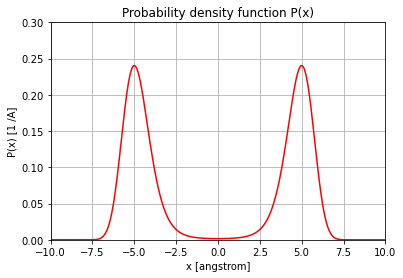

In [10]:
Px = 1/Zx * np.array([boltzmann_weight(xx, Eo, a, b, kBT) for xx in x_centers])

plt.plot(x_centers, Px, 'r-')
plt.ylim(0, 0.3)
plt.xlim(-10.0,10.0)
plt.grid()
plt.xlabel("x [{}]".format(unit.angstroms))
plt.ylabel("P(x) [{}]".format(1/unit.angstroms))
plt.title("Probability density function P(x)")

plt.show()

Finnally, let's see the period of the small harmonic oscillations around each minimum. In this case, when the well is symmetric ($b=0$), it can be proved that:

\begin{equation}
T_{x} = 2\pi \sqrt{\frac{ma^{2}}{8E_{0}}}
\end{equation}

The integration timestep of our langevin dynamics should be at least 10 times smaller than the fastest small harmonic oscillation around a minimum. Let's calculate $T_{x}$ to have our first time reference to choose the integration timestep:

In [11]:
omega_x = np.sqrt((8.0*Eo)/(mass*a**2))
T_x = 2*np.pi/omega_x

The integration timestep should be smaller than:

In [12]:
T_x/10.0

Quantity(value=0.3135078458129027, unit=picosecond)

## Along Y and Z

Our external potential along the Y and Z axes behave harmonically. The only interesting thing here is the classical oscillation period in both dimensions. The widely accepted rule of thumb to choose the integration timestep of a dynamics says: "the fastest classical oscillation should be described with at least ten points". As such, in this case it can be proved that

\begin{equation}
T_{y} = 2\pi \sqrt{\frac{m}{k}}
\end{equation}

And the integration timestep should be smaller than:

In [13]:
omega_y = np.sqrt(k/mass)
T_y = 2*np.pi/omega_y

T_y/10.0

Quantity(value=0.3071737010403021, unit=picosecond)

We will then work with a 0.2 ps integration timestep.

## The Langevin dynamics simulation

Let's now simulate the langevin dynamics of the system along 1 microsecond with a 0.2 ps integration timestep. The coordinates of the particle will be stored every 10 ps.

There is python script in this directory named `double_well.py`. Run it this way:

```bash
./double_well.py -i data.yaml -o traj.txt
```

Where `data.yaml` is a YAML file with the input parameters:

```yaml
n_particles : 1
mass : 100.0 amu

temperature : 300.0 kelvin
friction : 1.0 1/picoseconds

Eo : 3.0 kilocalories/mole
a : 5.0 angstroms
b : 0.0 kilocalories/mole
k : 1.0 kilocalories/(mole*angstrom**2)

simulation_time : 5.0 microseconds
saving_time : 10.0 picoseconds
integration_timestep : 0.2 picoseconds

platform_name : CUDA
```

And `traj.txt` is the output trajectory file: time in nanoseconds and coordinates $x$, $y$ y $z$ in angstroms.

Let's read the output trajectory:

In [14]:
times = []
positions = []

with open('traj.txt', 'r') as fff:
    for line in fff:
        if not line.startswith('#'):
            t, x, y, z = line.split(' ')
            times.append(float(t))
            positions.append([float(x), float(y) , float(z)])

times = np.array(times) * unit.nanoseconds
positions = np.array(positions) * unit.angstroms

Let's see the time evolution of the first 1000 x, y and z coordinates stored in our trajectory:

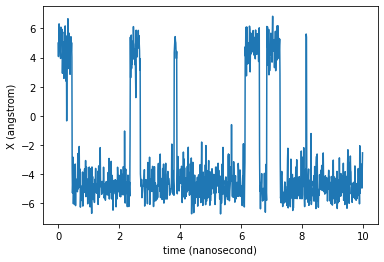

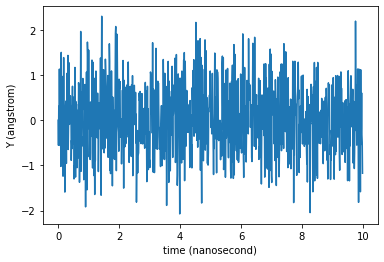

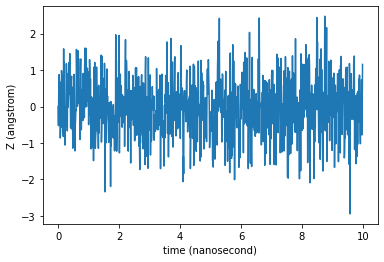

In [15]:
for ii, axis_label in zip(range(3),['X','Y','Z']):
    plt.plot(times[:1000], positions[:1000, ii])
    plt.ylabel('{} ({})'.format(axis_label, positions.unit))
    plt.xlabel('time ({})'.format(times.unit))
    plt.show()

Let's finally compare the theoretical probability density function $P(x)$ with the occupation density distribution observed along the trajectory:

In [16]:
Px_traj, _ = np.histogram(positions[:,0], bins=x_bins, density=True)

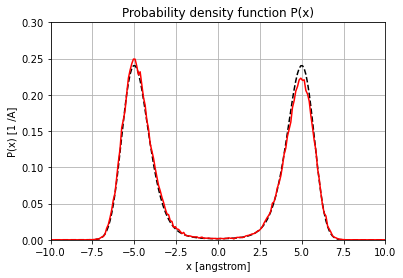

In [17]:
plt.plot(x_centers, Px, 'k--')
plt.plot(x_centers, Px_traj, 'r-')
plt.ylim(0, 0.3)
plt.xlim(-10.0,10.0)
plt.grid()
plt.xlabel("x [{}]".format(unit.angstroms))
plt.ylabel("P(x) [{}]".format(1/unit.angstroms))
plt.title("Probability density function P(x)")
plt.show()

By eye we could agree that the trajectory is close to be representative of the equilibrium. We should probably work with a larger trajectory: 5 microseconds?